# Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий

**Цель:** изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.

Для выполнения работы используются язык **Python** и библиотеки **PM4PY**, **Pandas**.

**Данные:**

## Начало работы. Чтение журнала событий

Библиотека **pm4py** работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Для соответствующих форматов в модуле есть два метода:
- **converter** из `pm4py.objects.conversion.log` (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий; 
- **importer** из `pm4py.objects.log.importer.xes` (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.

Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки `pm4py.objects.conversion.log.converter` преобразуем его в журнал событий.


In [2]:
# Установка библиотеки для Process mining
# !pip install pm4py

In [3]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [4]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [6]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


**Перед началом работы с любым набором данных, необходимо сначала его изучить:**
- названия колонок
- типы данных
- пропущенные значения
- и другое

In [8]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [12]:
log_csv = log_csv.rename(columns={
    ' DateTime': 'DateTime', 
    ' action': 'action', 
    ' org:resource': 'org:resource'
    })

In [13]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv['DateTime'] = pd.to_datetime(log_csv['DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   patient       690 non-null    object        
 1   action        690 non-null    object        
 2   org:resource  690 non-null    object        
 3   DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [35]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={'DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [36]:
case_starts_ends = case_starts_ends.reset_index()

In [37]:
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 

In [39]:
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv['DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend_x,casestart_x,caseend_y,casestart_y,caseend_x,casestart_x,relativetime,relativetime_s,relativedays,caseend_y,casestart_y,caseend,casestart
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11


In [40]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend_x,casestart_x,caseend_y,casestart_y,caseend_x,casestart_x,relativetime,relativetime_s,relativedays,caseend_y,casestart_y,caseend,casestart,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32


In [44]:
import seaborn as sns

<AxesSubplot:xlabel='relativetime_s', ylabel='patient'>

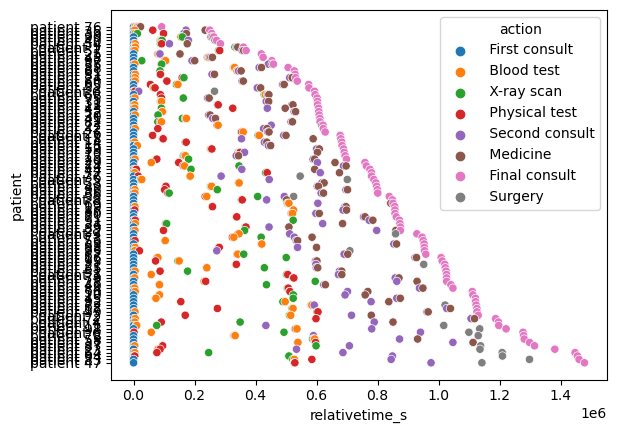

In [46]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered['action'])

In [48]:
patient_events = pd.crosstab(log_csv['patient'], log_csv['action']) 
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [49]:
len(log_csv['patient'].unique())

100

In [50]:
patient_events.sum()

action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

In [51]:
import matplotlib.pyplot as plt

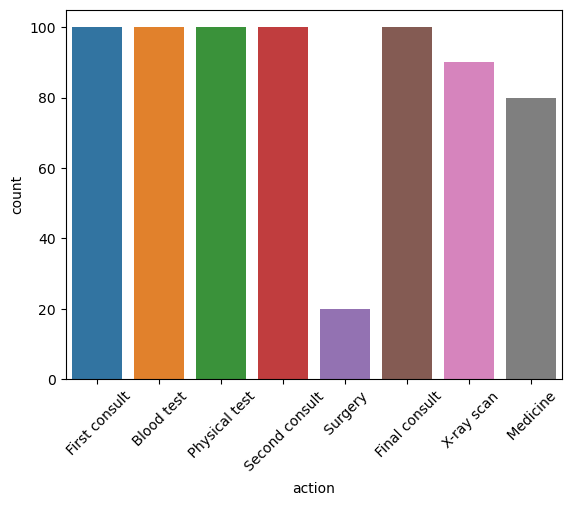

In [54]:
sns.countplot(x=log_csv['action'])
plt.xticks(rotation=45)
plt.show()

In [55]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

**Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:**

- **Идентификатор случая (case id):** хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
- **Деятельность (activity name):** хранит действия, выполняемые в рамках событий журнала.
- **Отметка времени (timestamp):** хранит дату и время регистрации событий журнала.
- **Ресурс (resource):** хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
- **Прочее (other data):** сюда попадает вся оставшаяся в журнале (не интересная нам) информация. 

В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [56]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {'DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 'action': 'concept:name',
                 'org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend_x,casestart_x,caseend_y,casestart_y,caseend_x,casestart_x,relativetime,relativetime_s,relativedays,caseend_y,casestart_y,caseend,casestart,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,2017-01-09 08:29:28,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,2017-05-31 12:46:43,2017-05-18 11:57:11,2017-05-31 12:46:43,2017-05-18 11:57:11,13 days 00:49:32


In [57]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

/opt/anaconda3/envs/laboratory-work-env/lib/python3.10/site-packages/pm4py/util/pandas_utils.py:39: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df.to_dict('records')


pm4py.objects.log.obj.EventLog

In [58]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend_x': Timestamp('2017-01-09 08:29:28'), 'casestart_x': Timestamp('2017-01-02 11:40:11'), 'caseend_y': Timestamp('2017-01-09 08:29:28'), 'casestart_y': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend_x': Timestamp('2017-01-09 08:29:28'), 'casestart_x': Timestamp('2017-01-02 11:40:11'), 'caseend_y': Timestamp('2017-01-09 08:29:28'), 'casestart_y': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caseen

In [59]:
log_csv.shape

(690, 18)

In [60]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [61]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [62]:
len(event_log[0])

6

**Важно!** помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [63]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [64]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [65]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [66]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

## Построение модели по журналу событий

### Alpha Miner

**Alpha miner** — один из самых известных алгоритмов интеллектуального анализа процессов и один из первых алгоритмов, способных обнаруживать параллелизм. Алгоритм использует прямую последовательность , причинно -следственные , параллельные и несвязанные отношения между переходами в журнале для обнаружения сети рабочего процесса.

http://mlwiki.org/index.php/Alpha_Algorithm

In [67]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

Полученный процесс мы можем отобразить с помощью **Сетей Петри**.

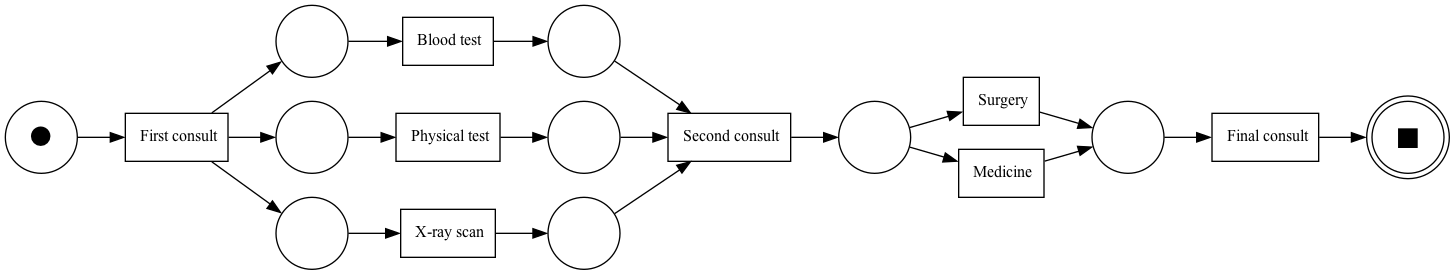

In [68]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

Чтобы получить представление о частоте переходов, можно установить параметр `pn_visualizer.Variants.FREQUENCY` при вызове `pn_visualizer.apply()`.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

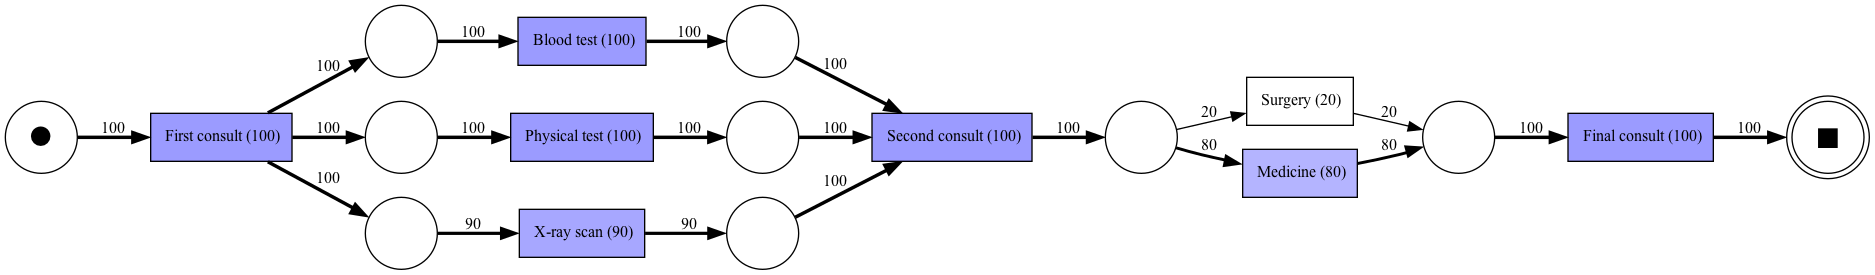

In [69]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [70]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция `get_transition_performance_with_token_replay` принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [71]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [72]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( Blood test, ' Blood test')", "( X-ray scan, ' X-ray scan')", "( Physical test, ' Physical test')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])

In [73]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend_x,casestart_x,caseend_y,casestart_y,caseend_x,casestart_x,relativetime,relativetime_s,relativedays,caseend_y,casestart_y,caseend,casestart,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,2017-01-31 15:49:44,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34


<AxesSubplot:xlabel='time:timestamp', ylabel='org:resource'>

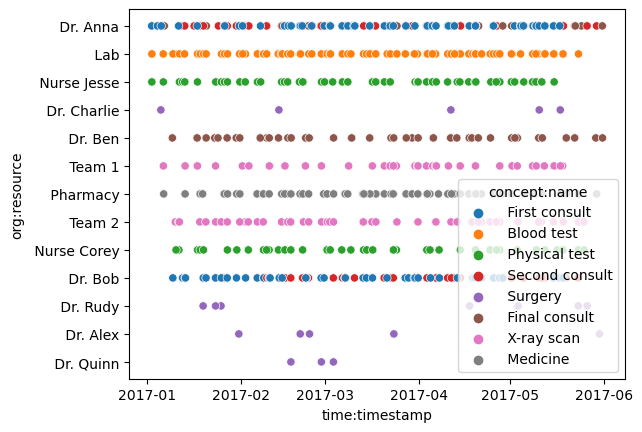

In [74]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

## Задания. Изучение журнала событий

1. Каково минимальное и максимальное количество событий в одном случае?
2. Какие события являются общими для всех процессов?
3. Найдите наибоее часто встречающуюся последовательность событий.
4. Какой пациент на лечение тратил меньше всего времени, а какой больше?
6. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)
7. Pation 13 с каким врачом/врачами он/она консультировался?
8. Какое событие является наиболее ресурсоёмким в данном журнале событий?
9. Есть ли врачи или медсестры, которые перегружены работой?
10. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?
11. Какие события связаны с узкими местами и какие ресурсы задействованы?
12. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?
13. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.
Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis